# Goal

I try to train a SVM on the MNIST dataset reducing the dimensions with PCA to a number that I can manage in some minutes with my notebook.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from time import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import math

# Some helper functions first 

I prepared a couple of functions to see the pictures before and after the dimensionality reduction.

In [9]:
# Plots the image represented by a row
def plot_number(row, w=28, h=28, labels=True):
    if labels:
        # the first column contains the label
        label = row[0]
        # The rest of columns are pixels
        pixels = row[1:]
    else:
        label = ''
        # The rest of columns are pixels
        pixels = row[0:]
    
#    print(row.shape, pixels.shape)
        

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    if labels:
        plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')

# Plots a whole slice of pictures
def plot_slice(rows, size_w=28, size_h=28, labels=True):
    num = rows.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.ix[n], size_w, size_h, labels)
    plt.show()


### Loading the training set
Let's load the dataset and see some basic info.

In [3]:
train = pd.read_csv('D:/Projects/Digit Recognizer/train.csv')
#train = pd.read_csv('train.csv')
print(train.shape)
train.sample(5)


(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
31311,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14178,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11565,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41578,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23865,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Visualizing some rows

Plotting a slice to see correspondence between labels and pictures.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


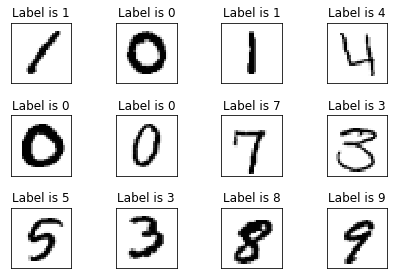

In [12]:
# Plotting first few rows
plot_slice(train[0:12])


## Dimensionality reduction

I try to see if a PCA can help to reduce the number of features without affecting too much information. First of all I split the whole dataset in features and class, then I prepare the split of both sets to training and test set.

In [13]:
X_train = train.drop(['label'], axis='columns', inplace=False)
y_train = train['label']

from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.30, random_state=4)


The `n_components` variable here is crucial. With a value of 16 the model can be trained in seconds and still achieve a `0.97229` score in the Leaderboard. I use a perfect square value because I want to see how it looks the reduced-dimension image.

I've seen that using 49 components resulted in a smaller score, maybe that means that the final model is more over-fitted than the 16 components one.

In [14]:
n_components = 16
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)


done in 15.744s


Let's see the variance histogram.

0.595346149244291

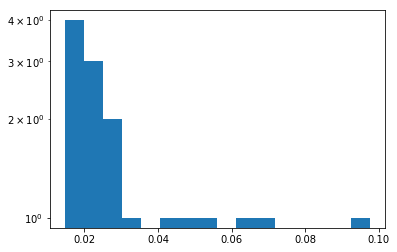

In [15]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
pca.explained_variance_ratio_.sum()


Even though 16 components collect 59% of variance and 49 components get 82%, the former performs better at submission.

Let's see how the smaller pictures look.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


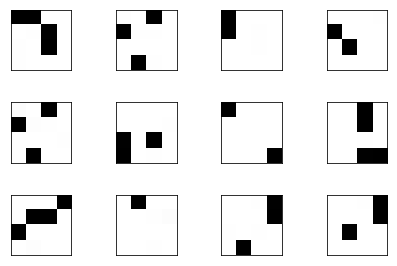

In [16]:
plot_slice(pd.DataFrame(data=X_train_pca[0:12]), size_w=4, size_h=4, labels=False)

Hope someone could explain these spots :D

I've removed the real grid search parameters here because it takes too long to make it online

In [ ]:
param_grid = { "C" : [0.1]
              , "gamma" : [0.1]}
rf = SVC()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train_pca, y_train)

print(gs.best_score_)
print(gs.best_params_)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
bp = gs.best_params_

t0 = time()
clf = SVC(C=bp['C'], kernel='rbf', gamma=bp['gamma'])
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))


In [ ]:
clf.score(pca.transform(X_ts), y_ts)

Nice score with a little effort.

In [ ]:
#val = pd.read_csv('test.csv')
val = pd.read_csv('../input/test.csv')
pred = clf.predict(pca.transform(val))
# ImageId,Label

val['Label'] = pd.Series(pred)
val['ImageId'] = val.index +1
sub = val[['ImageId','Label']]

sub.to_csv('submission.csv', index=False)

## Conclusions

It's been a very interesting experiment on how to reduce the features number to train the model in a decent time and still keep a goode score. It's good to see that I could reduce the number of features from __784 to 16__ with a __97%__ of overall score.

A next step could be using a Neural Network to see if there are improvements in the training time or score.

Any comment is appreciated!